# Customer segmentation


**1. data preprocessing**

**2. Exploration**

   - 2.1 Countries
   - 2.2 Consumers and products
        * 2.2.1 Cancelling orders
        * 2.2.2 StockCode
        * 2.2.3 Basket Price
        * 2.2.4 Frequency of purchases

**3. Indications on the type of products purchased**

   - 3.1 Description of the products
   - 3.2 Definition of product categories
        * 3.2.1 Data encoding
        * 3.2.2 Creating product clusters
        * 3.2.3 Characterization of the content of clusters
   
**4. Categories of consumers**

   - 4.1 Formatting data
        * 4.1.1 Grouping products by order
        * 4.1.2 Separation of data over time
        * 4.1.3 Consumer Order Combinations
   - 4.2 Creating customer categories
        * 4.2.1 Data encoding
        * 4.2.2 Creating customer categories

**5. Classification of customers**

   - 5.1 Support Vector Machine Classifier (SVC)
        * 5.1.1 Confusion matrix
        * 5.1.2 Learning curve
   - 5.2 Logistic Regression
   - 5.3 k-Nearest Neighbors
   - 5.4 Decision Tree
   - 5.5 Random Forest
   - 5.6 AdaBoost
   - 5.7 Gradient Boosting Classifier
   - 5.8 A democratic choice
   
**6. Testing predictions**

**7. Conclusion**

This notebook aims at analyzing the content of an e-commerce database that lists purchases made by $\sim$4000 customers over a period of one year. Based on this analysis, I develop a model that allows to anticipate the purchases that will be made by a new customer, during the following year and this, from its first purchase.
____

___________
###### the initial dataframe contained 542000 rows and 8 columns. I had to delete some data to reduce the size of my dataset because it was too heavy to store on github.

###### if you want more information on dataset processing click [here](https://www.kaggle.com/bobirino/kernels)
__________________

## 1. Data preprocessing

First step: we load all the modules that will be used in this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
#from kmodes import kmodes
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import PCA
from IPython.display import display, HTML
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

then the dataframe containing the data from e-commerce. Below, I also give some basic information on the content of the dataframe: the type of the various variables, the number of null values and the percentage with respect to the set of dataframe entries.

In [2]:
#__________________
# read the datafile
df_initial = pd.read_excel('customers_segmentation.xlsx',dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)
#______
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)
#__________________
# show first lines
display(df_initial[:5])

Dataframe dimensions: (5000, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,13,0,0,0,0,0
null values (%),0,0,0.26,0,0,0,0,0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
132961,577516,21916,SET 12 RETRO WHITE CHALK STICKS,1,2011-11-20 13:08:00,0.42,16533,United Kingdom
32590,546523,22993,SET OF 4 PANTRY JELLY MOULDS,12,2011-03-14 12:42:00,1.25,13319,United Kingdom
53024,553542,48138,DOORMAT UNION FLAG,1,2011-05-17 15:34:00,14.13,nan,United Kingdom
96088,567612,22086,PAPER CHAIN KIT 50'S CHRISTMAS,6,2011-09-21 11:48:00,2.95,17164,United Kingdom
38579,548484,20914,SET/5 RED RETROSPOT LID GLASS BOWLS,1,2011-03-31 12:43:00,2.95,13571,United Kingdom


In [3]:
df_initial.shape

(5000, 8)

If one looks at the number of null values in the dataframe, an interesting finding is that $\sim$25% of entries are not assigned to a particular user. It is impossible to impute values for the user and these entries are thus a priori unusable. So I delete them from the dataframe.

In [4]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (5000, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,13,0,0,0,0,0
null values (%),0,0,0.26,0,0,0,0,0


I check for duplicate entries and delete them if necessary:

In [5]:
print('Entrées dupliquées: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Entrées dupliquées: 2


OK, therefore, by removing these entries we end up with a dataframe filled to 100% on all variables!

___
## 2. Exploration

This dataframe contains 8 variables that correspond to:

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  <br>
**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
**Description**: Product (item) name. Nominal. <br>
**Quantity**: The quantities of each product (item) per transaction. Numeric.	<br>
**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated. <br>
**UnitPrice**: Unit price. Numeric, Product price per unit in sterling. <br>
**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
**Country**: Country name. Nominal, the name of the country where each customer resides.<br>

### 2.1 Countries

Nb. de pays dans le dataframe: 30


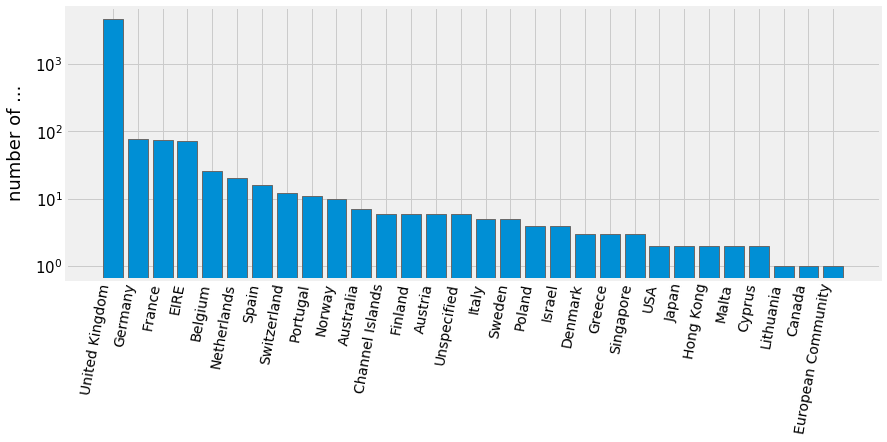

In [6]:
test = df_initial['Country'].value_counts()
print('Nb. de pays dans le dataframe: {}'.format(len(test)))
#_________________________________
fig = plt.figure(figsize = (13,5))
x_axis = range(len(test))
plt.bar(x_axis, np.array(test.values), align = 'center', log = True)
x_label = np.array(test.index)
plt.xticks(x_axis, x_label, ha = 'right', fontsize = 14)
plt.yticks(fontsize = 15)
plt.ylabel("number of ...", fontsize = 18, labelpad = 10)
plt.xticks(rotation=80);

___
### 2.2 Customers and products

The dataframe contains $\sim$ 400,000 entries. What is the number of users and products on these entries?

In [7]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,1891,3643,1689


It can be seen that the data concern 4372 users and that they bought 3684 different products. The total number of transactions carried out is in the order of $\sim$22'000, that is, on average, 5 transactions per customer per year.

Now I will determine the number of products purchased in each transaction:

In [8]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12352,567505,1
1,12358,581232,2
2,12359,555477,1
3,12360,571705,1
4,12362,551346,1
5,12362,C579178,1
6,12364,563854,2
7,12364,573401,1
8,12364,580152,1
9,12367,580716,1


The first lines of this list indicate several things worthy of interest, which will guide the rest of the analysis:
- the existence of an entry with the prefix C at the level of the variable InvoiceNo: this indicates the transactions that have been canceled
- the existence of users who only came once and only purchased one product (e.g. no. 12346)
- the existence of frequent users and buying a large number of items with each order

___
#### 2.2.1 Cancelling orders

First of all, I count the number of transactions corresponding to cancellations of orders.

In [9]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].astype(str).apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])
#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders cancelled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12352,567505,1,0
1,12358,581232,2,0
2,12359,555477,1,0
3,12360,571705,1,0
4,12362,551346,1,0


Number of orders cancelled: 83/3643 (2.28%) 


We note that the number of cancellations is consistent ($\sim$16% of the total number of transactions).
As an illustration, let's look at the first lines of the dataframe:

In [10]:
display(df_initial.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
95908,567505,22692,DOORMAT WELCOME TO OUR HOME,2,2011-09-20 14:34:00,8.25,12352,Norway
147379,581232,22059,CERAMIC STRAWBERRY DESIGN MUG,24,2011-12-08 10:26:00,0.39,12358,Austria
147378,581232,15056BL,EDWARDIAN PARASOL BLACK,24,2011-12-08 10:26:00,5.95,12358,Austria
58112,555477,23162,REGENCY TEA STRAINER,4,2011-06-03 12:26:00,3.75,12359,Cyprus
111197,571705,22816,CARD MOTORBIKE SANTA,12,2011-10-18 15:22:00,0.42,12360,Austria


On these few lines, we notice that when canceling, we end up with 2 transactions in the dataframe (ordering and cancellation). So I decide to check if this is true for all entries.
To do this, I decide to locate the entries indicating a negative quantity and check whether there is * systematically * a command indicating the same quantity (but positive) and with the same description (** CustomerID **, ** Description ** and ** UnitPrice **):

In [11]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID', 'Quantity', 'StockCode', 'Description', 'UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print('Hypothèse non valide')
        break

CustomerID                 12637
Quantity                      -2
StockCode                 84927E
Description    FLOWERS TILE HOOK
UnitPrice                    2.1
Name: 19954, dtype: object
Hypothèse non valide


I note that the starting hypothesis is not verified because of the existence of an entry whose description is "_Discount_". I test again the hypothesis made initially by not taking into account these inputs:

In [12]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID', 'Quantity', 'StockCode', 'Description', 'UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print('Hypothèse non valide')
        break

19954 CustomerID                 12637
Quantity                      -2
StockCode                 84927E
Description    FLOWERS TILE HOOK
UnitPrice                    2.1
Name: 19954, dtype: object
Hypothèse non valide


and I again find that this hypothesis is not verified. So the cancellations do not necessarily correspond to orders that would have been made beforehand.

At this point, I decide to create a new variable in the dataframe or I indicate if part of the command has been canceled. At the level of entries that indicate a cancellation but without compensation at the level of the orders, a certain number of them correspond to the cancellation of orders placed before the month of December 2010 (entry point of the database). I decide to delete these entries.

In [13]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
#    if index%1000 == 0: print(index)
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()
    #___________________________________________________
    # annulation sans contrepartie au niveau des achats
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #_____________________________________________________
    # annulation avec 1 contrepartie au niveau des achats
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #_______________________________________________________________________________
    # il existe plusieurs contreparties au niveau des achats: on annule la dernière
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

The number of entries to delete in the dataframe is:

In [14]:
print(len(entry_to_remove), len(doubtfull_entry))

1 95


Among these entries, the lines listed in the * doubtfull_entry * list correspond to the entries indicating a cancellation but for which there is no command beforehand. In practice, I decide to delete all of these entries, which count respectively for  $\sim$1.4% and 0.2% of the dataframe entries.

Now I check the number of entries that correspond to cancellations and that have not been deleted with the previous filter:

In [15]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("nb d'entrées non supprimées: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

nb d'entrées non supprimées: 0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled


If one looks, for example, at the purchases of the consumer of one of the above entries and corresponding to the same product as that of the cancellation, one observes:

In [16]:
df_cleaned[(df_cleaned['CustomerID'] == 14048) & (df_cleaned['StockCode'] == '22464')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled


We see that the quantity canceled is greater than the sum of the previous purchases.
___
#### 2.2.2 StockCode

Above, it has been seen that some values of the ** StockCode ** variable indicate a particular transaction (i.e. D for Discount). I check the contents of this variable by looking for the set of codes that would contain only letters:

In [17]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+',na=True, regex=True)]['StockCode'].unique()
list_special_codes

array([21916, 22993, 48138, ..., 21001, 22911, 22581], dtype=object)

In [18]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

21916           -> SET 12 RETRO WHITE CHALK STICKS
22993           -> SET OF 4 PANTRY JELLY MOULDS  
48138           -> DOORMAT UNION FLAG            
22086           -> PAPER CHAIN KIT 50'S CHRISTMAS 
20914           -> SET/5 RED RETROSPOT LID GLASS BOWLS
84978           -> HANGING HEART JAR T-LIGHT HOLDER
22771           -> CLEAR DRAWER KNOB ACRYLIC EDWARDIAN
22896           -> PEG BAG APPLES DESIGN         
23128           -> FELTCRAFT BOY JEAN-PAUL KIT   
23322           -> LARGE WHITE HEART OF WICKER   
22909           -> SET OF 20 VINTAGE CHRISTMAS NAPKINS
20724           -> RED RETROSPOT CHARLOTTE BAG   
22659           -> LUNCH BOX I LOVE LONDON       
22073           -> RED RETROSPOT STORAGE JAR     
23333           -> IVORY WICKER HEART MEDIUM     
22690           -> DOORMAT HOME SWEET HOME BLUE  
22426           -> ENAMEL WASH BOWL CREAM        
22713           -> CARD I LOVE LONDON            
22084           -> PAPER CHAIN KIT EMPIRE        
20750           -> RED RETROSPO

22197           -> POPCORN HOLDER                
22918           -> HERB MARKER PARSLEY           
23176           -> ABC TREASURE BOOK BOX         
21755           -> LOVE BUILDING BLOCK WORD      
23215           -> JINGLE BELL HEART ANTIQUE SILVER
20726           -> LUNCH BAG WOODLAND            
22806           -> SET OF 6 T-LIGHTS WEDDING CAKE 
84375           -> SET OF 20 KIDS COOKIE CUTTERS 
23290           -> SPACEBOY CHILDRENS BOWL       
22222           -> CAKE PLATE LOVEBIRD WHITE     
82600           -> NO SINGING METAL SIGN         
22423           -> REGENCY CAKESTAND 3 TIER      
22331           -> WOODLAND PARTY BAG + STICKER SET
20616           -> CHERRY BLOSSOM PASSPORT COVER 
C2              -> CARRIAGE                      
22427           -> ENAMEL FLOWER JUG CREAM       
20723           -> STRAWBERRY CHARLOTTE BAG      
23048           -> SET OF 10 LANTERNS FAIRY LIGHT STAR
22804           -> CANDLEHOLDER PINK HANGING HEART
85175           -> CACTI T-LIGHT CANDLE

22953           -> BIRTHDAY PARTY CORDON BARRIER TAPE
21259           -> VICTORIAN SEWING BOX SMALL    
21026           -> SPACE OWL                     
22747           -> POPPY'S PLAYHOUSE BATHROOM    
23433           -> HANGING QUILTED PATCHWORK APPLES
23255           -> CHILDRENS CUTLERY CIRCUS PARADE
23093           -> SMALL PARISIENNE HEART PHOTO FRAME 
71459           -> HANGING JAM JAR T-LIGHT HOLDER
22236           -> CAKE STAND 3 TIER MAGIC GARDEN
22333           -> RETROSPOT PARTY BAG + STICKER SET
22428           -> ENAMEL FIRE BUCKET CREAM      
22158           -> 3 HEARTS HANGING DECORATION RUSTIC
23198           -> PANTRY MAGNETIC  SHOPPING LIST
21677           -> HEARTS  STICKERS              
22550           -> HOLIDAY FUN LUDO              
22546           -> MINI JIGSAW PURDEY            
22470           -> HEART OF WICKER LARGE         
22971           -> QUEENS GUARD COFFEE MUG       
22515           -> CHILDS GARDEN SPADE PINK      
22560           -> TRADITIONAL 

23523           -> WALL ART TREASURE AHOY        
22071           -> SMALL WHITE RETROSPOT MUG IN BOX 
23353           -> 6 GIFT TAGS VINTAGE CHRISTMAS 
22577           -> WOODEN HEART CHRISTMAS SCANDINAVIAN
22729           -> ALARM CLOCK BAKELIKE ORANGE   
21747           -> SMALL SKULL WINDMILL          
21395           -> BLUE POLKADOT BEAKER          
23323           -> WHITE WICKER STAR             
23243           -> SET OF TEA COFFEE SUGAR TINS PANTRY
22501           -> PICNIC BASKET WICKER LARGE    
23320           -> GIANT 50'S CHRISTMAS CRACKER  
22175           -> PINK OWL SOFT TOY             
84828           -> JUNGLE POPSICLES ICE LOLLY MOULDS
22473           -> TV DINNER TRAY VINTAGE PAISLEY
22147           -> FELTCRAFT BUTTERFLY HEARTS    
22092           -> BLUE PAISLEY TISSUE BOX       
21220           -> SET/4 BADGES DOGS             
22595           -> GINGHAM HEART DECORATION      
21165           -> BEWARE OF THE CAT METAL SIGN  
21949           -> SET OF 6 STRAWB

22508           -> DOORSTOP RETROSPOT HEART      
22890           -> NOVELTY BISCUITS CAKE STAND 3 TIER
21210           -> SET OF 72 RETROSPOT PAPER  DOILIES
20969           -> RED FLORAL FELTCRAFT SHOULDER BAG
23228           -> FILIGREE HEART BIRD WHITE     
22947           -> WOODEN ADVENT CALENDAR RED    
21277           -> FRENCH STYLE EMBOSSED HEART CABINET
22754           -> SMALL RED BABUSHKA NOTEBOOK   
22596           -> CHRISTMAS STAR WISH LIST CHALKBOARD
22458           -> CAST IRON HOOK GARDEN FORK    
22314           -> OFFICE MUG WARMER CHOC+BLUE   
82580           -> BATHROOM METAL SIGN           
21709           -> FOLDING UMBRELLA CHOCOLATE POLKADOT
21067           -> VINTAGE RED TEATIME MUG       
21002           -> ROSE DU SUD DRAWSTRING BAG    
22981           -> PANTRY APPLE CORER            
23129           -> HEART SHAPED HOLLY WREATH     
23494           -> VINTAGE DOILY DELUXE SEWING KIT 
22930           -> BAKING MOULD HEART MILK CHOCOLATE
22665           -> 

23330           -> DECORATIVE WICKER HEART MEDIUM
37464           -> ROBOT MUG IN DISPLAY BOX      
20775           -> DAISY NOTEBOOK                
22311           -> OFFICE MUG WARMER BLACK+SILVER 
22318           -> FIVE HEART HANGING DECORATION 
85015           -> SET OF 12  VINTAGE POSTCARD SET
21872           -> GLAMOROUS  MUG                
22403           -> MAGNETS PACK OF 4 VINTAGE LABELS 
22743           -> MAKE YOUR OWN FLOWERPOWER CARD KIT
22231           -> JIGSAW TREE WITH BIRDHOUSE    
37342           -> POLKADOT COFFEE CUP & SAUCER PINK
22921           -> HERB MARKER CHIVES            
22723           -> SET OF 6 HERB TINS SKETCHBOOK 
22199           -> FRYING PAN RED RETROSPOT      
22973           -> CHILDREN'S CIRCUS PARADE MUG  
20668           -> DISCO BALL CHRISTMAS DECORATION
90022           -> EDWARDIAN DROP EARRINGS JET BLACK
22592           -> CARDHOLDER HOLLY WREATH METAL 
22389           -> PAPERWEIGHT SAVE THE PLANET   
21121           -> SET/10 RED POLK

21122           -> SET/10 PINK POLKADOT PARTY CANDLES
22923           -> FRIDGE MAGNETS LES ENFANTS ASSORTED
22270           -> HAPPY EASTER HANGING DECORATION
22730           -> ALARM CLOCK BAKELIKE IVORY    
22886           -> NUMBER TILE VINTAGE FONT 7    
21402           -> RED  EGG  SPOON               
23005           -> TRAVEL CARD WALLET I LOVE LONDON
22082           -> RIBBON REEL STRIPES DESIGN    
22778           -> GLASS CLOCHE SMALL            
23289           -> DOLLY GIRL CHILDRENS BOWL     
21427           -> SKULLS STORAGE BOX SMALL      
22837           -> HOT WATER BOTTLE BABUSHKA     
22594           -> CHRISTMAS GINGHAM TREE        
21584           -> RETROSPOT SMALL TUBE MATCHES  
20675           -> BLUE POLKADOT BOWL            
23302           -> KNEELING MAT HOUSEWORK  DESIGN
22361           -> GLASS JAR DAISY FRESH COTTON WOOL
22974           -> CHILDRENS DOLLY GIRL MUG      
23369           -> SET 36 COLOUR PENCILS LOVE LONDON
21739           -> COSY SLIPPER 

23018           -> LARGE APOTHECARY MEASURING JAR 
22422           -> TOOTHPASTE TUBE PEN           
21817           -> GLITTER CHRISTMAS TREE        
21462           -> NURSERY A,B,C PAINTED LETTERS 
21900           -> KEY FOB , SHED                
22306           -> SILVER MUG BONE CHINA TREE OF LIFE
21672           -> WHITE SPOT RED CERAMIC DRAWER KNOB
22440           -> BALLOON WATER BOMB PACK OF 35 
84006           -> MAGIC TREE -PAPER FLOWERS     
22646           -> CERAMIC STRAWBERRY CAKE MONEY BANK
23380           -> PACK OF 12 VINTAGE DOILY TISSUES
21189           -> WHITE HONEYCOMB PAPER GARLAND 
22537           -> MAGIC DRAWING SLATE DINOSAUR  
21307           -> SET/4 BUTTERFLY MIRROR MAGNETS
21865           -> PINK UNION JACK  PASSPORT COVER 
22994           -> TRAVEL CARD WALLET RETROSPOT  
23271           -> CHRISTMAS TABLE SILVER CANDLE SPIKE
23135           -> SMALL ZINC HEART WALL ORGANISER
72127           -> COLUMBIAN CANDLE ROUND        
23331           -> DECORATI

22572           -> ROCKING HORSE GREEN CHRISTMAS 
85094           -> CANDY SPOT EGG WARMER RABBIT  
23035           -> DRAWER KNOB CERAMIC IVORY     
85093           -> CANDY SPOT EGG WARMER HARE    
85107           -> CUT GLASS T-LIGHT HOLDER OCTAGON
22412           -> METAL SIGN NEIGHBOURHOOD WITCH 
21640           -> ASSORTED TUTTI FRUTTI  FOB NOTEBOOK
22461           -> SAVOY ART DECO CLOCK          
84457           -> SET/3 RABBITS FLOWER SKIPPPING ROPE
22229           -> BUNNY WOODEN PAINTED WITH FLOWER 
21892           -> TRADITIONAL WOODEN CATCH CUP GAME 
23382           -> BOX OF 6 CHRISTMAS CAKE DECORATIONS
20705           -> MRS ROBOT SOFT TOY            
21883           -> STARS GIFT TAPE               
23566           -> EGG CUP MILKMAID HEIDI        
22782           -> SET 3 WICKER STORAGE BASKETS  
22340           -> NOEL GARLAND PAINTED ZINC     
23239           -> SET OF 4 KNICK KNACK TINS POPPIES
21192           -> WHITE BELL HONEYCOMB PAPER    
90099           -> NEC

There are several types of peculiar transactions, connected e.g. to port charges or bank charges.


___
#### 2.2.3 Basket Price

I create a new variable that indicates the amount of the purchase:

In [19]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,TotalPrice
95908,567505,22692,DOORMAT WELCOME TO OUR HOME,2,2011-09-20 14:34:00,8.25,12352,Norway,0,16.50
147378,581232,15056BL,EDWARDIAN PARASOL BLACK,24,2011-12-08 10:26:00,5.95,12358,Austria,0,142.80
147379,581232,22059,CERAMIC STRAWBERRY DESIGN MUG,24,2011-12-08 10:26:00,0.39,12358,Austria,0,9.36
58112,555477,23162,REGENCY TEA STRAINER,4,2011-06-03 12:26:00,3.75,12359,Cyprus,0,15.00
111197,571705,22816,CARD MOTORBIKE SANTA,12,2011-10-18 15:22:00,0.42,12360,Austria,0,5.04


At the level of this dataframe, the amounts are indicated for each product purchased during an order. I collect all the purchases made during a single order and to recover the total amount:

In [20]:
#___________________________________________
# somme des achats / utilisateur & commande
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#_____________________
# date de la commande
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection des entrées significatives:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
0,12352,567505,16.50,2011-09-20 14:34:00
1,12358,581232,152.16,2011-12-08 10:26:00
2,12359,555477,15.00,2011-06-03 12:26:00
3,12360,571705,5.04,2011-10-18 15:22:00
4,12362,551346,17.00,2011-04-28 09:12:00
5,12364,563854,30.00,2011-08-19 15:24:00


In order to have a global view of the type of order performed at this dataset, I determine how the purchases are divided up in relation to their amounts:

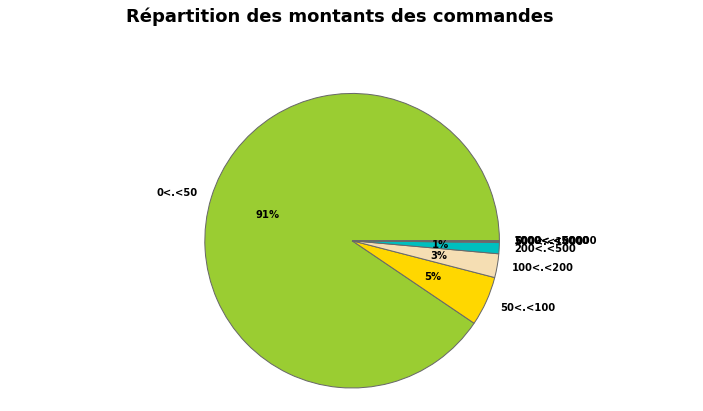

In [21]:
#____________________
# Décompte des achats
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
#____________________________________________
# Représentation du nombre d'achats / montant        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Répartition des montants des commandes", ha='center', fontsize = 18);

It can be seen that the vast majority of orders made relate to relatively large purchases given that $\sim$65% of purchases have an amount in excess of £ 200.

____
#### 2.2.4 Frequency of purchases

Next, I am interested in the frequency of visits of different users. For this, I look at the number of transactions associated with each of them. I also describe the amounts associated with all these transactions:

In [22]:
nb_transactions_per_user = basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean'])
nb_transactions_per_user.reset_index(drop = False, inplace = True)
nb_transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean
0,12352,1,16.50,16.50,16.50
1,12358,1,152.16,152.16,152.16
2,12359,1,15.00,15.00,15.00
3,12360,1,5.04,5.04,5.04
4,12362,1,17.00,17.00,17.00


____
## 3. Indications on the type of products purchased

At the dataset level, products are uniquely identified using the ** StockCode ** variable. The type of product in question is described in the variable ** Description **. In this section, I am looking at whether it is possible to use the content of this variable in order to group the products into different categories.

___
### 3.1 Description of the products

As a first step, I extract from the variable ** Description ** the information that will be useful. To do this, I use the following function:

In [23]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = str(s).lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as input the dataframe and analyzes the contents of the **Description** column by performing the following operations:

- retrieval of the names (own, common) appearing in the description of the products
- for each name, I extract the root of the word and save the set of names associated with a particular root
- count the number of times each root appears at the dataframe level
- when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular / plural variants)

The first step of the analysis is to retrieve the list of products present in the dataset:

In [24]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

Once this list is created, I use the function I previously defined in order to analyze the content of the descriptions of the different products:

In [25]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1006


The execution of this function returns three variables:
- `keywords`: the list of extracted keywords
- `keywords_roots`: a dictionary where the keys are the roots of the keywords and the values are list of words corresponding to the roots
- `count_keywords`: dictionary listing the number of products where the different names appear

At this point, I turn the contents of the dictionary `count_keywords` into a list, so that you can sort the keywords according to their frequency:

In [26]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

which makes it possible to create a representation of the most common keywords:

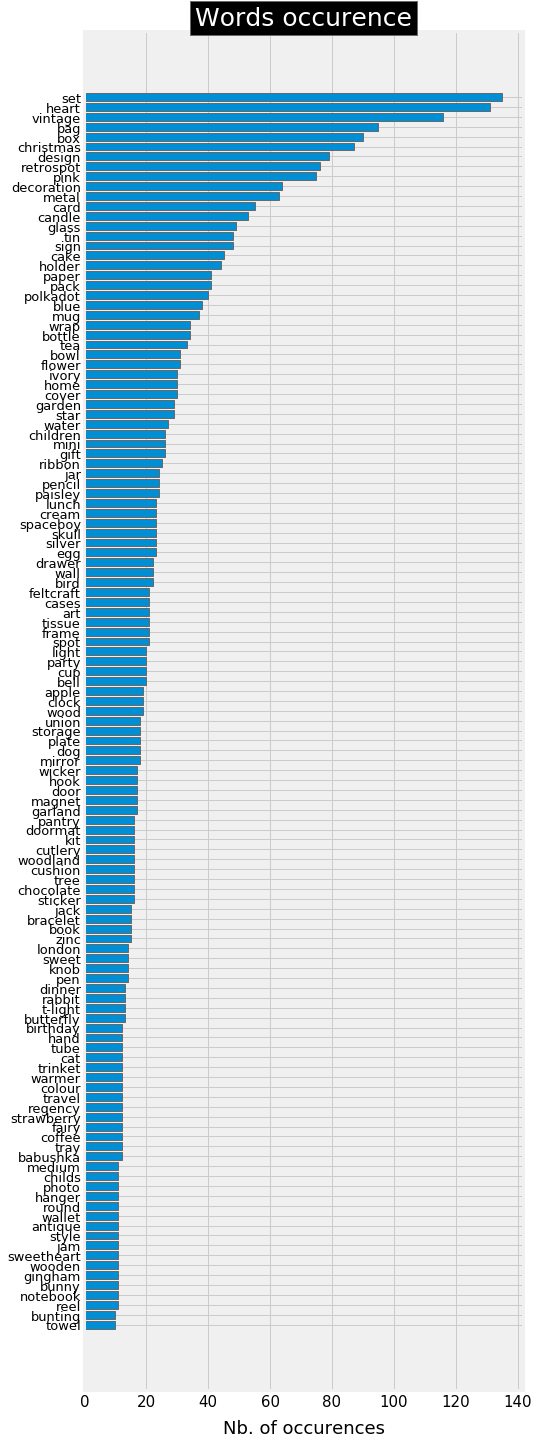

In [27]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

___
### 3.2 Definition of product categories

The list that was obtained contains more than 1400 keywords of which the most frequent appear in more than 200 products. On the level of this list, however, I note that some of the names are abhérent. Others are informative, like colors.
I therefore dismis these words from the analysis that follows and moreover, I only consider the key words that appear more than 13 time

In [28]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('mots conservés:', len(list_products))

mots conservés: 92


____
#### 3.2.1 Data encoding

Now I will use these keywords to create product groups. Firstly,
I create the matrix $X$ according to the schema:
    
|   | word 1  |  ...  | word j  | ...  |  N  |
|:-:|---|---|---|---|---|
| product 1  | $a_{1,1}$  |     |   |   | $a_{1,N}$  |
| ...        |            |     | ...  |   |   |
|product i   |    ...     |     | $a_{i,j}$    |   | ...  |
|...         |            |     |  ... |   |   |
| product M  | $a_{M,1}$  |     |   |   | $a_{M,N}$   |

where the coefficient $ a_ {i, j} $ is 1 if the description of the product n $ $ i $ contains the word n $ $ j $, and 0 otherwise:

In [29]:
liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits.astype(str)))

This last matrix indicates the words contained in the description of the products on the principle of *one-hot-encoding*. In practice, I have found that by indicating moreover the price range in which the different products are located, more balanced groups are obtained in terms of the number of elements.
So I add 6 columns to this matrix, where I indicate the price range of the products:

In [30]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

and I check the number of products in the different price ranges:

In [31]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       403                 
1<.<2       464                 
2<.<3       329                 
3<.<5       343                 
5<.<10      238                 
.>10        107                 


____
#### 3.2.2 Creating Product Clusters

Now, I am grouping products into different classes. In the case of matrices with binary encoding, the most suitable metric for the calculation of distances is [Hamming's metric](https://en.wikipedia.org/wiki/Distance_de_Hamming). I use this metric by importing the module [kmodes](https://pypi.python.org/pypi/kmodes/). Note that the ** kmeans ** method of sklearn uses a Euclidean distance which could be used but which is not to be progrege in the case of categorical variables. In order to define (approximately) the number of clusters that best represents the data, I use the silhouette score:

In [32]:
matrix = X.as_matrix()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.12567999790745646
For n_clusters = 4 The average silhouette_score is : 0.1563773678902737
For n_clusters = 5 The average silhouette_score is : 0.18184387204137167
For n_clusters = 6 The average silhouette_score is : 0.1817283666132201
For n_clusters = 7 The average silhouette_score is : 0.19463256805701157
For n_clusters = 8 The average silhouette_score is : 0.17748282375241908
For n_clusters = 9 The average silhouette_score is : 0.18656962158024643


In [33]:
#matrix = X.as_matrix()
#_____________________________________________
# Détermination de nombre optimal de clusters
#for n_clusters in range(3,10):
#    km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=3, verbose=0)
#    clusters = km.fit_predict(matrix)
#    silhouette_avg = silhouette_score(matrix, clusters)
#    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

In practice, the scores obtained above can be considered equivalent since, depending on the run, scores of $ 0.1 \pm 0.05 $ will be obtained for all clusters with `n_clusters` $> $ 3 (one obtains possibly slightly lower scores for the first cluster). On the other hand, I found that, beyond 5 clusters, some clusters contained very few elements. I therefore choose to separate the dataset into 5 clusters. In order to ensure a good classification, I go so far as to obtain the best accessible silhouette score, which in this case is around 0.15:

In [34]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.1814773527001961


___
#### 3.2.3 Characterization of the contents of clusters

I check the number of elements in each class:

In [35]:
pd.Series(clusters).value_counts()

3    464
2    450
1    403
0    329
4    238
dtype: int64


**a / _Silhouette intra-cluster score_**

In order to have an insight into the quality of the classification, we can represent the silhouette scores of each element of the different clusters. This is the object of the following figure from the [documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) of sklearn (and the corresponding python code):

In [36]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        #color = plt.cm.spectral(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

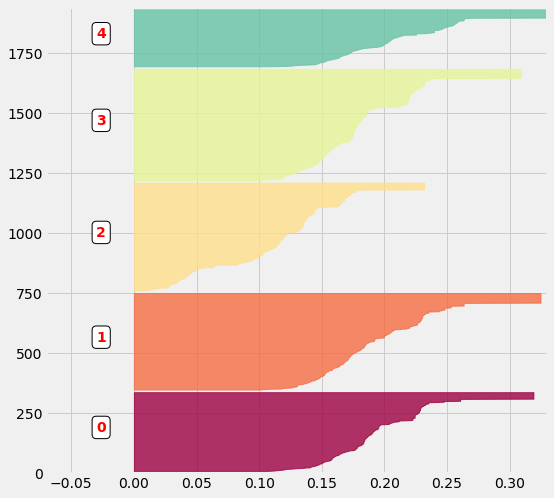

In [37]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

**c / Component Analysis**

In order to ensure that these clusters are truly distinct, I look at the different elements within these clusters. Given the large number of variables of the initial matrix, I first make a PCA:

In [38]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

et je regarde dans quelle mesure les différents vecteurs expliquent la variance des données:

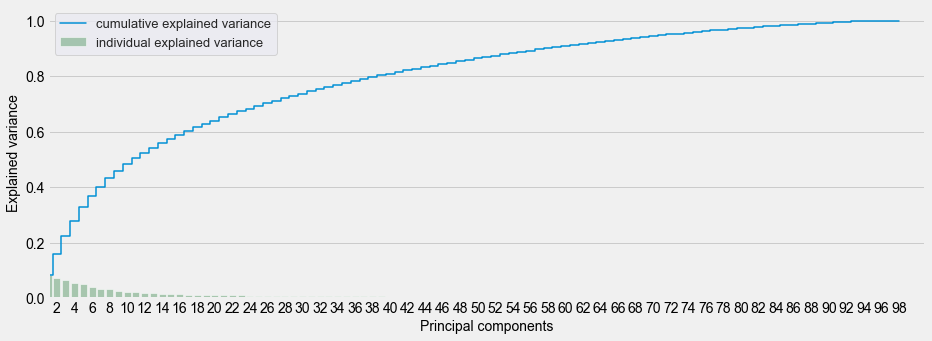

In [39]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

It is found that the number of components required to explain the data set is extremely important: it is necessary to use more than 100 main components to explain 90% of the variance of the data. In practice, I decide to keep only a limited number of components insofar as this decomposition is only intended to visualize the data:

In [40]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

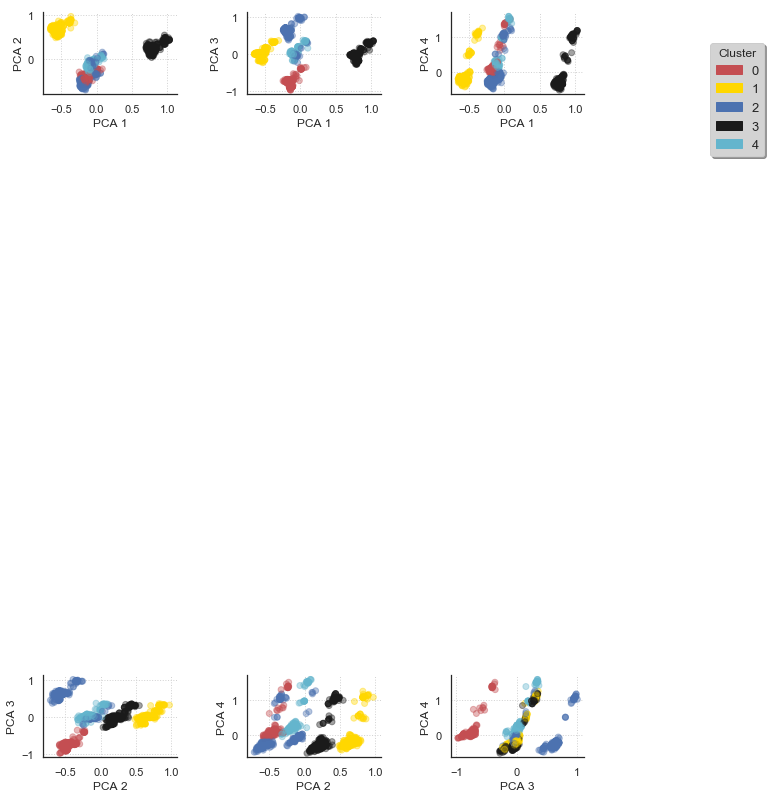

In [41]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (10,20))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(3,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray',linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

___
## 4. Categories de consommateurs

### 4.1 Formatting data

In the previous section, the different products were grouped into five clusters. In order to prepare the rest of the analysis, a first step consists in introducing this information into the dataframe containing the set of commands. To do this, I create the categorical variable **categ_product**:

In [42]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 
#__________________________________________________________________________
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

___
#### 4.1.1 Grouping products by order

In a second step, I decide to create the ** categ_N ** variables with $ N \ in [0: 4] $ which contain the amounts spent in each product category:

In [43]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
132961,577516,SET 12 RETRO WHITE CHALK STICKS,1,0.00,0.42,0.0,0.0,0.00
32590,546523,SET OF 4 PANTRY JELLY MOULDS,3,0.00,0.00,0.0,15.0,0.00
53024,553542,DOORMAT UNION FLAG,4,0.00,0.00,0.0,0.0,14.13
96088,567612,PAPER CHAIN KIT 50'S CHRISTMAS,2,0.00,0.00,17.7,0.0,0.00
38579,548484,SET/5 RED RETROSPOT LID GLASS BOWLS,0,2.95,0.00,0.0,0.0,0.00


At this stage, it is found that the information relating to the same command is dispersed over several lines of the dataframe (one line per product). So I decide to collect the information related to a particular order on a single entry. I therefore create a new dataframe containing for each order the amount of the basket, as well as the way that amount is distributed according to the 5 categories of products:

In [44]:
#___________________________________________
# somme des achats / utilisateur & commande
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#____________________________________________________________
# pourcentage du prix de la commande / categorie de produit
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 
#_____________________
# date de la commande
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection des entrées significatives:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
0,12352,567505,16.50,0.0,0.00,16.5,0.00,0.0,2011-09-20 14:34:00
1,12358,581232,152.16,0.0,0.00,0.0,9.36,142.8,2011-12-08 10:26:00
2,12359,555477,15.00,0.0,0.00,15.0,0.00,0.0,2011-06-03 12:26:00
3,12360,571705,5.04,0.0,5.04,0.0,0.00,0.0,2011-10-18 15:22:00
4,12362,551346,17.00,0.0,0.00,17.0,0.00,0.0,2011-04-28 09:12:00


#### 4.1.2 Separation of data over time

The dataframe `basket_price` contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit. In order to be able to test the model in a realistic way, I split the data set by retaining the first 10 months to develop the model and the following two months to test it:

In [45]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:34:00 -> 2011-12-09 12:00:00


In [46]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < datetime.date(2011,10,1)]
set_test         = basket_price[basket_price['InvoiceDate'] >= datetime.date(2011,10,1)]
basket_price = set_entrainement.copy(deep = True)

____
#### 4.1.3 Consumer Order Combinations

In a second step, I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [47]:
#________________________________________________________________
# nb de visites et stats sur le montant du panier / utilisateurs
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12352,1,16.5,16.5,16.5,16.5,0.0,0.0,100.0,0.0,0.0
1,12359,1,15.0,15.0,15.0,15.0,0.0,0.0,100.0,0.0,0.0
2,12362,1,17.0,17.0,17.0,17.0,0.0,0.0,100.0,0.0,0.0
3,12364,1,30.0,30.0,30.0,30.0,0.0,34.0,0.0,0.0,66.0
4,12370,1,60.0,60.0,60.0,60.0,0.0,0.0,0.0,100.0,0.0


Finally, I define two additional variables that give the number of days elapsed since the first purchase (**FirstPurchase**) and the number of days since the last purchase (**LastPurchase**):

In [48]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12352,1,16.5,16.5,16.5,16.5,0.0,0.0,100.0,0.0,0.0,10,10
1,12359,1,15.0,15.0,15.0,15.0,0.0,0.0,100.0,0.0,0.0,119,119
2,12362,1,17.0,17.0,17.0,17.0,0.0,0.0,100.0,0.0,0.0,155,155
3,12364,1,30.0,30.0,30.0,30.0,0.0,34.0,0.0,0.0,66.0,42,42
4,12370,1,60.0,60.0,60.0,60.0,0.0,0.0,0.0,100.0,0.0,290,290


A customer category that will pay particular attention is that of customers who make only one purchase, and one of the objectives may be, for example, to target these customers in order to retain them. In part, I find that this type of customer represents 1/3 of the customers listed:

In [49]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("nb. de clients avec achat unique: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

nb. de clients avec achat unique: 873/1254  (69.62%)


___
### 4.2 Creating customer categories

#### 4.2.1 Data encoding

The dataframe `transactions_per_user` contains a summary of all the commands made by the different clients. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of clients and for this I use a subset of variables:

In [50]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].as_matrix()

In practice, the different variables that have been selected have quite different domains of variation and before continuing the analysis, I therefore create a matrix where these data will be standardized:

In [51]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [ 1.98644338 19.87476874 30.36667464 24.35919869 18.99166994 16.92175222
 24.40096037 24.19300603 15.49261143]


In the following, I will create client clusters. In practice, before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the `scaled_matrix` matrix. In this case, I will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. I therefore perform a PCA beforehand:

In [52]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

and I represents the amount of variance explained by each of the components:

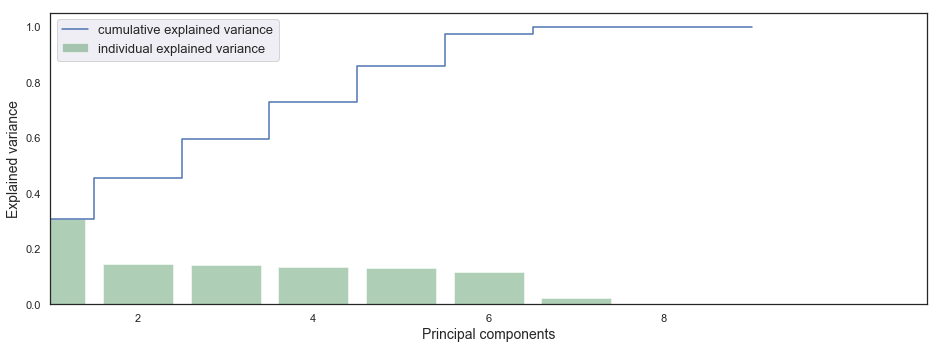

In [53]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

___
#### 4.2.2 Creating customer categories

At this point, I define client clusters from the standardized matrix that was defined earlier and using the `k-means` algorithm from` scikit-learn`. I choose the number of clusters based on the silhouette score and I find that the best score is obtained by defining 11 clusters:

In [54]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.586


First, I look at the number of clients in each cluster:

In [55]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T

,6,2,4,3,8,1,9,0,10,7,5
nb. de clients,249,248,202,190,177,148,22,10,6,1,1


**a / _Report via the PCA_**

There is a certain disparity in the different groups that have been created, so I will now try to understand what each of these clusters is in order to validate (or not) the separation that has been made. At first, I use the result of the PCA:

In [56]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

to create a representation of the different clusters:

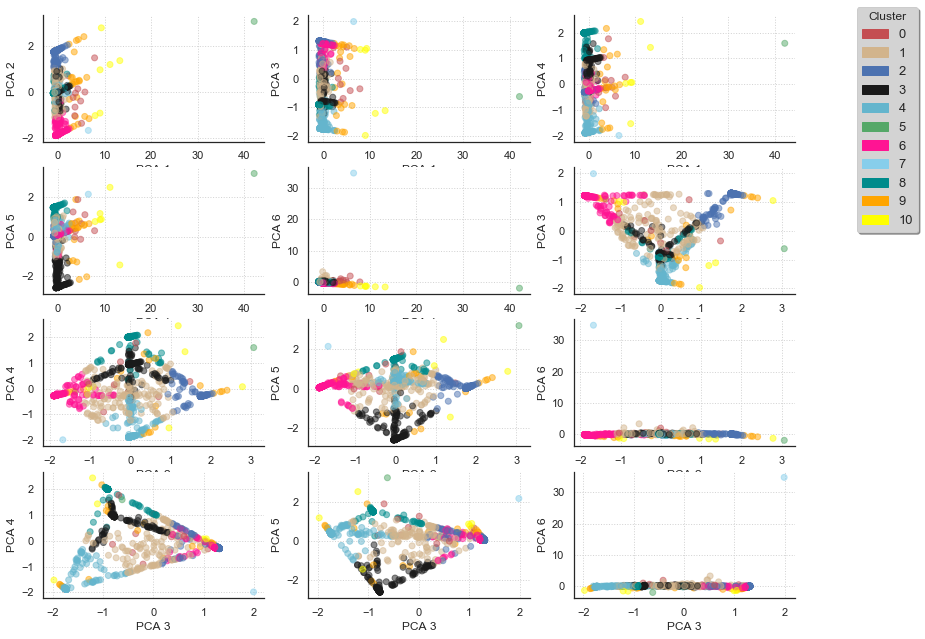

In [57]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

From this representation, it can be seen, for example, that the first principal component makes it possible to separate the clusters with few elements from the other clusters. More generally, it can be seen that, depending on the pair of PCAs considered, a specific separation of the different clusters is obtained that ultimately. Overall, we see that there is always a representation in which two clusters will appear to be disjoint.

**b/ _Score de silhouette intra-cluster_**

As with product categories, another way to look at the quality of separation is to look at silouhette scores within different clusters:


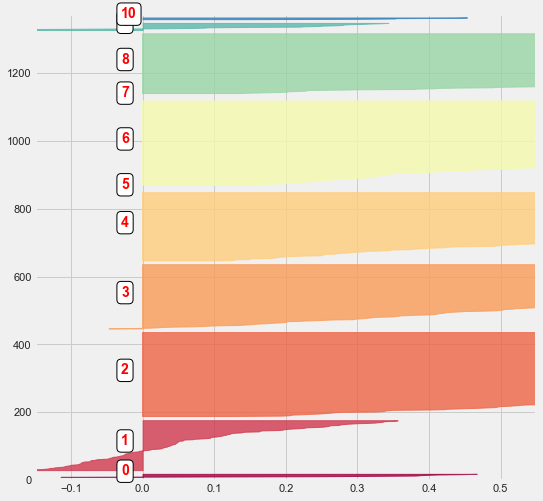

In [58]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

**c/ _Description détaillée des clients types_**

At this stage, I have verified that the different clusters are indeed disjoint (at least, in a global way). It remains to define the content of each of them and to understand the typical behavior of the customers present in each of them. In a first time, therefore, I add to the dataframe `selected_customers` a variable that defines the cluster to which each client belongs:

In [59]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, I average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets, the number of visits or the total sums spent by the clients of the different clusters. I also determine the number of clients in each group (variable ** size **):

In [60]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 1254


Finally, in order to re-organize the content of the dataframe by ordering the different clusters in relation to the expenditure in the different categories on the one hand and then on the total amount of expenditure, on the other hand:

In [61]:
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])
#___________________________________
liste_index_reordered = liste_index
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]
#___________________________________________________________
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,4.0,1.386139,16.459703,23.383069,19.985463,29.570000,91.910255,2.931726,0.922289,2.503735,1.731996,202
1,8.0,1.214689,11.092655,13.246836,12.179397,15.197288,0.804428,95.620513,1.273431,2.121929,0.179698,177
2,6.0,1.257028,18.623454,23.563695,20.861710,26.669116,1.050914,1.112012,94.952171,1.884420,1.000484,249
3,2.0,1.270161,14.097661,16.770968,15.349581,18.797258,1.172516,2.219933,0.152019,95.969111,0.486420,248
4,3.0,1.378947,19.612842,25.580947,22.261132,30.236737,2.353261,2.775883,3.637503,3.578955,87.654399,190
5,1.0,3.945946,10.608986,28.913581,17.706387,67.705000,22.983558,13.082071,29.800783,25.149872,8.983716,148
6,9.0,1.181818,140.451364,153.676364,147.786591,171.201364,20.057504,5.723906,30.304091,24.705027,19.209473,22
7,10.0,1.000000,329.126667,329.126667,329.126667,329.126667,16.666667,16.666667,33.333333,16.666667,16.666667,6
8,0.0,5.200000,39.133000,382.392000,167.352952,819.015000,15.203314,18.254438,42.458830,12.603600,11.479818,10
9,5.0,3.000000,748.440000,2061.000000,1574.480000,4723.440000,0.000000,0.000000,59.478685,0.000000,40.521315,1


**d / _Customers morphology_**

Finally, I created a representation of the different morphotypes. To do this, I define a class to create "Radar Charts" (which has been adapted from this [kernel](https://www.kaggle.com/yassineghouzam/don-t-know-why-employees-leave -read-this)):

In [62]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)


This provides a global view of the contents of each cluster:

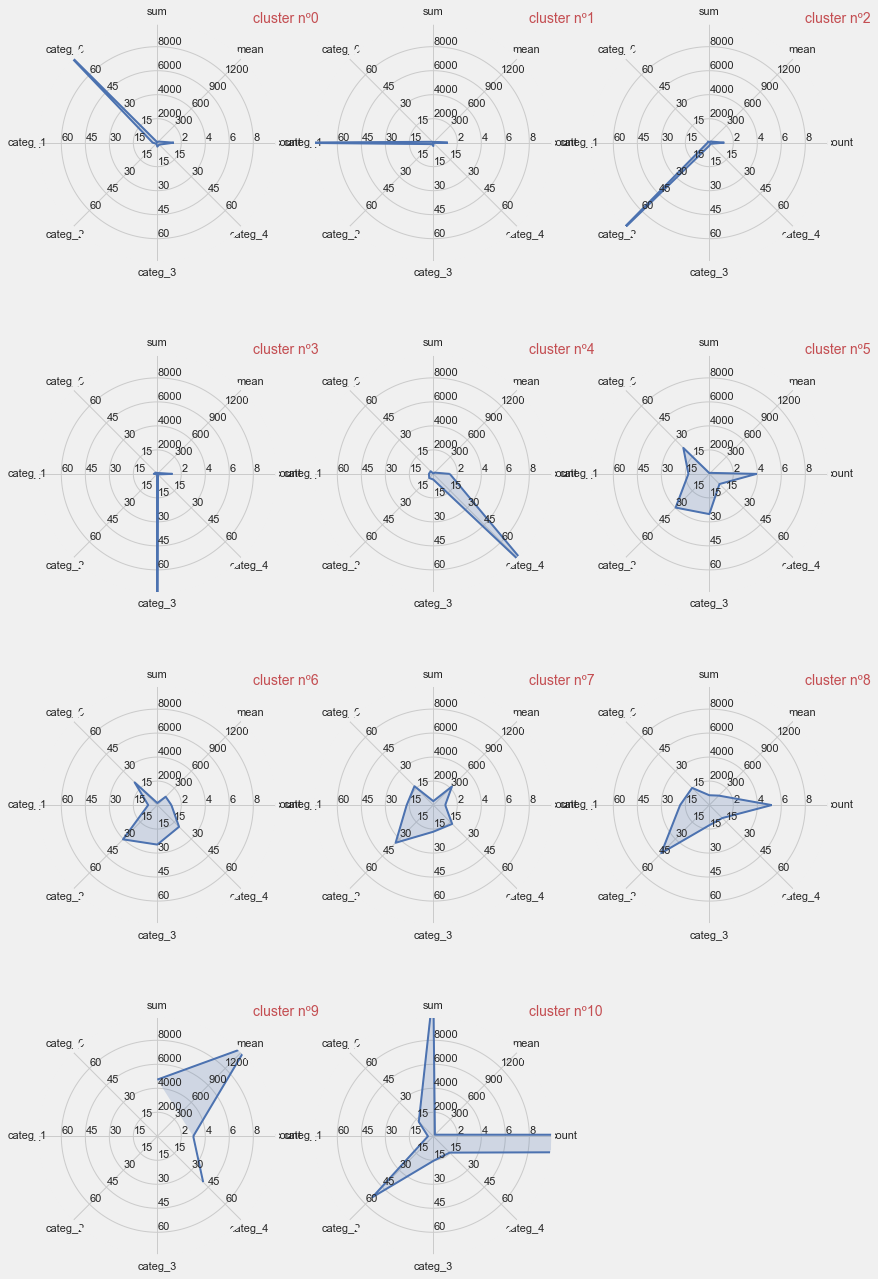

In [63]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1 

It can be seen, for example, that the first 5 clusters correspond to a strong preponderance of purchases in a particular category of products. Other clusters will differ from basket averages (**mean**), the total sum spent by the clients (**sum**) or the total number of visits made (**count**).

____
## 5. Classification of customers

In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section. The objective is to make this classification possible at the first visit. To fulfill this objective, I will test several classifiers implemented in `scikit-learn`. First, in order to simplify their use, I define a class that allows to interface several of the functionalities common to these different classifiers: 

In [64]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))
        

To the extent that the objective is to define the class to which a client belongs at the first visit, I only keep the variables that describe the content of the basket and do not take into account the variables related to the frequency of visits or changes in the time spent on money:

In [65]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

Finally, I separate the dataset into test and training sets:

In [66]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

___
### 5.1 Support Vector Machine Classifier (SVC)

The first classifier I use is the SVC classifier. In order to use it, I create an instance of the `Class_Fit` class and then call` grid_search () `. When calling this method, I provide as parameters:
- the hyperparameters for which I will seek an optimal value
- the number of folds to be used for cross-validation

In [67]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

Once this instance is created, I adjust the classifier to the training data:

In [68]:
svc.grid_fit(X = X_train, Y = Y_train)

I can then test the accuracy of the predictions on the data of the test set:

In [69]:
svc.grid_predict(X_test, Y_test)

Precision: 88.84 % 


___
#### 5.1.1 Confusion matrix

The accuracy of the results seems to be correct. Nevertheless, let us remember that when the different classes were defined, there was an imbalance in size between the different classes obtained. In particular, one class contains about 40% of clients. It is therefore interesting to look at how the predictions and real values compare to the breasts of the different classes. This is the subject of the confusion matrices and to represent them, I use the code of the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html):

In [70]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from which I create the following representation:

Confusion matrix, without normalization


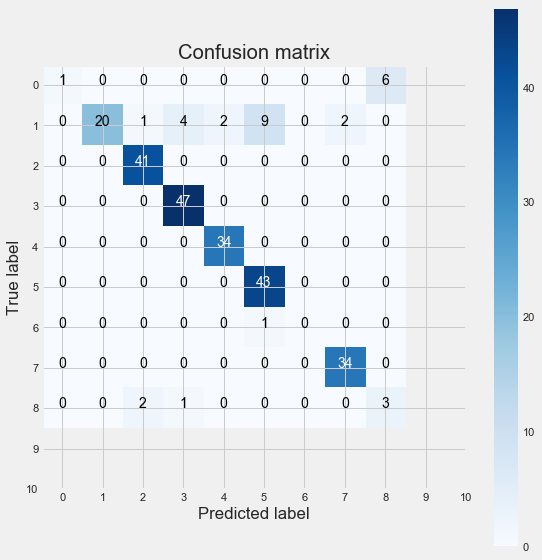

In [71]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

___
#### 5.1.2 Learning curve

A typical way to test the quality of a fit is to draw a learning curve. This type of curve makes it possible in particular to detect possible gaps in the model, linked for example to over-learning or under-learning. This also makes it possible to see if the modeling could benefit from a larger sampling of data. In order to represent this type of curve, I use the [scikit-learn documentation code again](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr- self-examples-model-selection-pad-learning-curve-py)

In [72]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

which allows me to represent the learning curve of the SVC classifier:

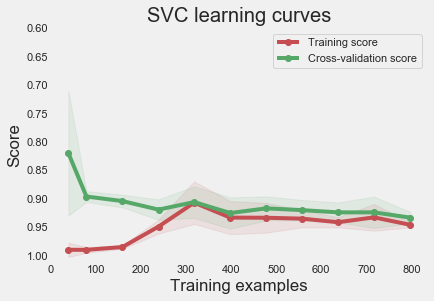

In [73]:
g = plot_learning_curve(svc.grid.best_estimator_, "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

On this curve, it can be seen, for example, that the drive and cross-validation curves converge to the same value when the sample size increases. This is typical of modeling with low variance and proves that the model does not suffer from over-learning. Also, it can be seen that the accuracy of the drive curve is correct. At this level, good precision is synonymous with low bias, which is equivalent to a model that does not suffer from under-learning.

___
### 5.2 Logistic Regression

I now look at the predictions obtained using a logistic regression. As before, I create an instance of the `Class_Fit` class, just the model on the training data and see how the predictions compare to the real values:

In [74]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 88.45 % 


Then I draw the learning curve to make sure of the quality of fit:

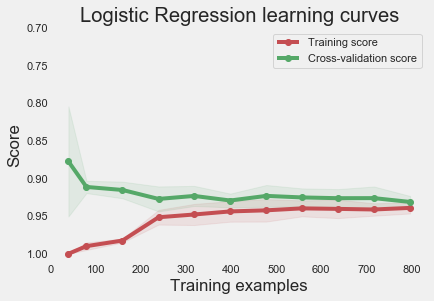

In [75]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.3 k-Nearest Neighbors

In [76]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 95.62 % 


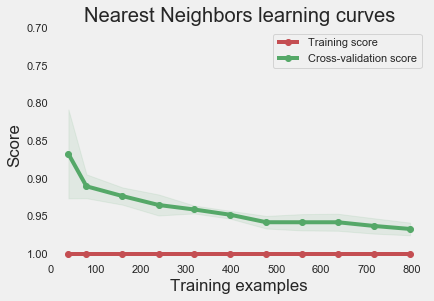

In [77]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.4 Decision Tree

In [78]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 93.63 % 


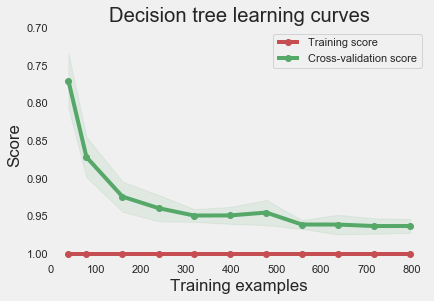

In [79]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.5 Random Forest

In [80]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 95.22 % 


In [81]:
rf.grid.best_params_

{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 40}

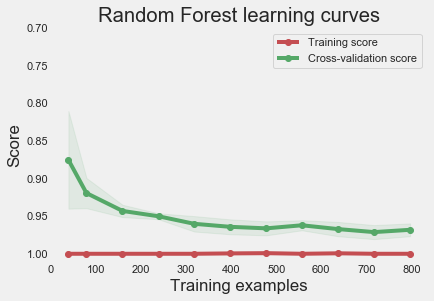

In [82]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.6 AdaBoost Classifier

In [83]:
from sklearn.ensemble import AdaBoostClassifier

In [84]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 17.53 % 


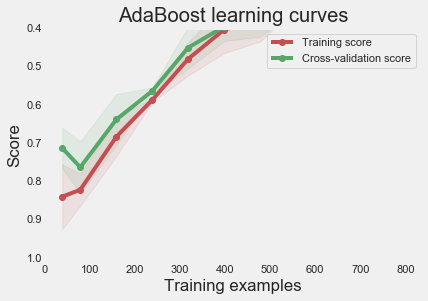

In [85]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.7 Gradient Boosting Classifier

In [86]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 96.81 % 


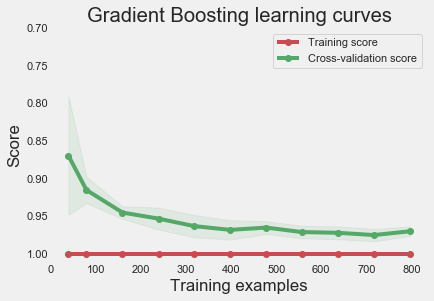

In [87]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

___
### 5.8 A democratic choice

Finally, the results of the different classifiers presented in the previous sections can be combined to improve the results of the classification model. A simple way to do this is to choose the most likely category for the clients based on the set of results provided by the different classifiers. To do this, I use the `VotingClassifier` method of` sklearn` package set. In a first step, I set the parameters of the different classifiers using the parameters that have been defined previously:

In [88]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

The classifiers are then defined:

In [89]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),('knn', knn_best)], voting='soft')    

that we then train:

In [90]:
votingC = votingC.fit(X_train, Y_train)

Finally, we can then create a prediction based on the predictions of the different classifiers:

In [91]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 96.81 % 


Note that at the definition of the `votingC` classifier, I used a sub-sample of all the classifiers defined above, and only retained the` Random Forest`, the `k-Nearest Neighbors` and the `Gradient Boosting`. In practice, this choice is based on the performance of the classification compared to the test carried out in the following section.

___
## 6. Testing predictions

In the previous section, more classifiers were trained so as to be able to determine the cattometry to which the consumers belong. The whole analysis relating to the definition of the categories or the training of the classifier is based on the data of the first 10 months of the dataset. Since the model has been defined, it is now a test and I use the data of the last two months that are in the dataframe `set_test`:

In [92]:
basket_price = set_test.copy(deep = True)

In a first step, I regroup reformattes these data according to the same procedure as used on the training set. However, I am correcting the data to take into account the difference in time between the two datasets and weights the variables ** count ** and ** sum ** to obtain an equivalence with the training set:

In [93]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

#_________________________________________
# Correction sur les différences de durée
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12358,5,152.16,152.16,152.16,760.8,0.0,0.0,0.0,6.15142,93.84858
1,12360,5,5.04,5.04,5.04,25.2,0.0,100.0,0.0,0.00000,0.00000
2,12364,10,5.04,5.04,5.04,50.4,0.0,100.0,0.0,0.00000,0.00000
3,12367,5,23.40,23.40,23.40,117.0,100.0,0.0,0.0,0.00000,0.00000
4,12374,5,14.22,14.22,14.22,71.1,0.0,0.0,100.0,0.00000,0.00000


Then, I convert the dataframe into a matrix and retain only variables that define the category to which consumers belong. At this level, I recall the method of normalization that had been used on the training set:

In [94]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
matrix_test = transactions_per_user[list_cols].as_matrix()
scaled_test_matrix = scaler.transform(matrix_test)

Each line in this matrix contains a consumer's buying habits. At this stage, it is a question of using these habits in order to define the category to which the consumer belongs. These categories have been established in Section 4. ** At this stage, it is important to bear in mind that this step does not correspond to the classification stage itself. Here, we prepare the test data by defining the category to which the customers belong. However, this definition uses data obtained over a period of 2 months (via the variables **count**, **min**, **max** and **sum**). The classifier defined in Section 5 uses a more restricted set of variables that will be defined from the first purchase of a client.

Here it is a question of using the available data over a period of two months and using this data to define the category to which the customers belong. Then, the classifier can be tested by comparing its predictions with these categories. In order to define the category to which the clients belong, I recall the instance of the `kmeans` method used in section 4. The` predict` method of this instance calculates the distance of the consumers from the centroids of the 11 client classes and the smallest distance will define the belonging to the different categories:

In [95]:
Y = kmeans.predict(scaled_test_matrix)

Finally, in order to prepare the execution of the classifier, it is sufficient to select the variables on which it acts:

In [96]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]

It remains only to examine the predictions of the different classifiers that have been trained in section 5:

In [97]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 94.64 % 
______________________________ 
Logostic Regression
Precision: 94.23 % 
______________________________ 
k-Nearest Neighbors
Precision: 97.12 % 
______________________________ 
Decision Tree
Precision: 97.53 % 
______________________________ 
Random Forest
Precision: 97.80 % 
______________________________ 
Gradient Boosting
Precision: 98.21 % 


Finally, as anticipated in Section 5.8, it is possible to improve the quality of the classifier by combining their respective predictions. At this level, I chose to mix Random Forest, Gradient Boosting and k-Nearest Neighbors predictions because this leads to a slight improvement in predictions:

In [98]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 98.21 % 


## 7. Conclusion

The work described in this notebook is based on a database providing details on purchases made on an e-commerce platform over a period of one year. Each entry in the dataset describes the purchase of a product, by a particular customer and on a given date. In total, approximately $ \ sim $ 4000 clients appear at the database level. Given the available information, I decided to develop a classifier that allows to anticipate the type of purchase that a customer will make, as well as the number of visits that he will make during a year, and this from its first visit to the e-commerce site.

The first stage of this work consisted in describing the different products sold by the site, which was the subject of a first classification. During this stage, I grouped the different products into 5 main categories of goods. In a second step, I performed a classification of the customers by analyzing their consumption habits over a period of 10 months. I have classified clients into 11 major categories based on the type of products they usually buy, the number of visitors they make in a year and the amount they spend on average and in total during the 10 months. These categories established, I finally trained several classifiers whose objective is to be able to classify consumers in one of these 11 categories and this from their first purchase. For this, the classifier is based on 5 variables which are:
- **mean**: amount of the basket of the current purchase
- **categ_N** with $ N \ in [0: 4] $: percentage spent in product category with index $ N $


Finally, the quality of the predictions of the different classifiers was tested over the last two months of the dataset. The data were then processed in two steps: first, the set of data was used to define the category to which each client belongs, and then the classifier predictions were compared to this category assignment. I then found that 75% of clients are awarded the right classes.
The performance of the classifier therefore seems correct given the potential shortcomings of the current model. In particular, a bias that has not been dealt with concerns the seasonality of purchases and the fact that purchasing habits will potentially depend on the time of year (for example, Christmas ). In practice, this seasonal effect may cause the categories defined over a 10-month period to be quite different from those extrapolated from the last two months. In order to correct such bias, it would be beneficial to have data that would cover a longer period of time.

